In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#from tensorflow.keras import layers
#from tensorflow.keras import regularizers
import keras_tuner as kt

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
#from sklearn.preprocessing import OneHotEncoder


tf.__version__

2023-12-04 16:44:27.211945: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-04 16:44:27.293806: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-04 16:44:27.741785: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-12-04 16:44:27.741830: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

'2.11.0'

In [2]:
# Load dataset
csv_file = '../../Datasets/dataset_Halogenos_Rmin.csv'
#csv_file = '../Dataset/dataset_augmented.csv'
#csv_file = '../Dataset/dataset_left.csv'
dataframe_raw = pd.read_csv(csv_file)
dataframe_raw = dataframe_raw.drop(dataframe_raw.columns[0],axis=1) # remove first column (no information there)
dataframe_raw.head()

,Pos1,Pos2,Pos3,Pos4,Pos5,Pos6,Pos7,Pos8,Pos9,Pos10,Pos11,Pos12,Pos13,Pos14,Pos15,Pos16,Nsubs,R,lambd
0,0,0,0,0,0,0,0,0,0,1,4,0,0,0,0,0,2,-273.2294,350.23
1,0,2,0,0,0,4,0,0,0,0,0,3,0,0,0,0,3,-244.0982,353.40
2,0,0,0,0,0,0,0,3,0,0,3,3,4,2,0,0,5,-194.6106,359.97
3,0,4,0,4,0,0,0,0,0,0,0,2,0,0,3,3,5,-237.2939,369.31
4,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4,0,2,-309.5538,347.50


In [3]:
dataframe = dataframe_raw.copy()

# Create a target variable
dataframe['target'] = dataframe['R']

# Create array with number of subtitutes
nsubs = []
nsubs[:] = dataframe['Nsubs']

# Drop unused features.
dataframe = dataframe.drop(columns=['R', 'lambd', 'Nsubs'])
dataframe.head()

,Pos1,Pos2,Pos3,Pos4,Pos5,Pos6,Pos7,Pos8,Pos9,Pos10,Pos11,Pos12,Pos13,Pos14,Pos15,Pos16,target
0,0,0,0,0,0,0,0,0,0,1,4,0,0,0,0,0,-273.2294
1,0,2,0,0,0,4,0,0,0,0,0,3,0,0,0,0,-244.0982
2,0,0,0,0,0,0,0,3,0,0,3,3,4,2,0,0,-194.6106
3,0,4,0,4,0,0,0,0,0,0,0,2,0,0,3,3,-237.2939
4,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4,0,-309.5538


1
32
151
202
209
210
378


Text(0, 0.5, 'count')

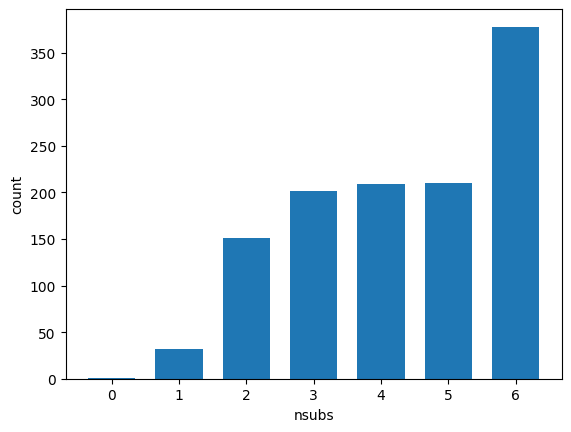

In [4]:
# number of substitutes

n0 = nsubs.count(0)
n1 = nsubs.count(1)
n2 = nsubs.count(2)
n3 = nsubs.count(3)
n4 = nsubs.count(4)
n5 = nsubs.count(5)
n6 = nsubs.count(6)
print(n0)
print(n1)
print(n2)
print(n3)
print(n4)
print(n5)
print(n6)

bin_edges = np.arange(-0.5,6.5+1,1)
#bin_edges = np.arange(-0.5,4.5+1,1)
plt.hist(nsubs, bins=bin_edges, rwidth=0.7)
plt.xlabel('nsubs')
plt.ylabel('count')

In [5]:
# Check overal statistis of each input feature 
dataframe.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pos1,1183.0,0.615385,1.202789,0.0000,0.00000,0.0000,1.00000,4.0000
Pos2,1183.0,0.701606,1.251621,0.0000,0.00000,0.0000,1.00000,4.0000
Pos3,1183.0,0.606086,1.205752,0.0000,0.00000,0.0000,0.00000,4.0000
Pos4,1183.0,0.655114,1.214439,0.0000,0.00000,0.0000,1.00000,4.0000
Pos5,1183.0,0.726120,1.301198,0.0000,0.00000,0.0000,1.00000,4.0000
Pos6,1183.0,0.639053,1.232964,0.0000,0.00000,0.0000,1.00000,4.0000
Pos7,1183.0,0.631445,1.207461,0.0000,0.00000,0.0000,1.00000,4.0000
Pos8,1183.0,0.689772,1.241263,0.0000,0.00000,0.0000,1.00000,4.0000
Pos9,1183.0,0.674556,1.233248,0.0000,0.00000,0.0000,1.00000,4.0000
Pos10,1183.0,0.716822,1.290383,0.0000,0.00000,0.0000,1.00000,4.0000


/tmp/ipykernel_95501/3989795848.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataframe[['target']])


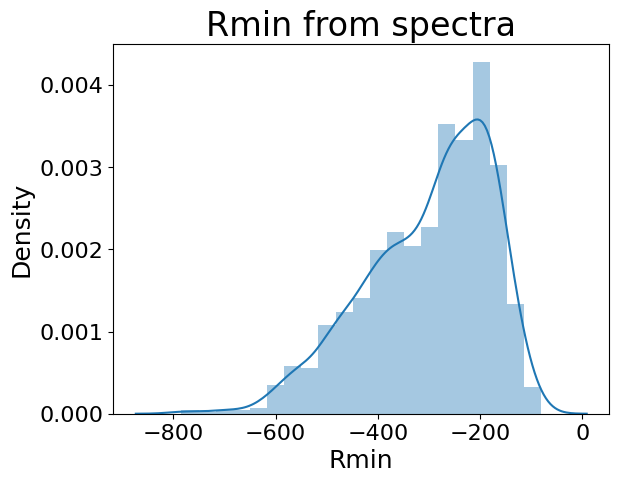

In [6]:
# Inspect the data with the joint distribition of a few pairs of columns from the training set

#sns.pairplot(dataframe[['target']], diag_kind='kde')
#sns.set_style('darkgrid')
sns.distplot(dataframe[['target']])
plt.title('Rmin from spectra',fontsize=24)
plt.xlabel('Rmin',fontsize=18)
plt.ylabel('Density',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

Text(0, 0.5, 'Rmin')

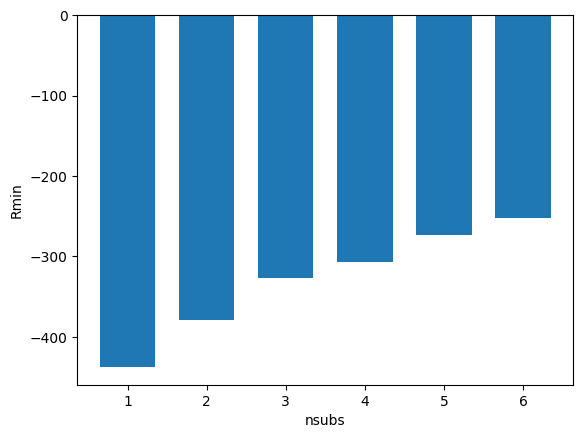

In [7]:
# Rmin as a function of nsubs
Rmin = []
Rmin[:] = dataframe['target']

nsubs1 = [i for i in range(len(nsubs)) if nsubs[i]==1]
nsubs2 = [i for i in range(len(nsubs)) if nsubs[i]==2]
nsubs3 = [i for i in range(len(nsubs)) if nsubs[i]==3]
nsubs4 = [i for i in range(len(nsubs)) if nsubs[i]==4]
nsubs5 = [i for i in range(len(nsubs)) if nsubs[i]==5]
nsubs6 = [i for i in range(len(nsubs)) if nsubs[i]==6]

Rmin1 = [Rmin[i] for i in nsubs1]
Rmin2 = [Rmin[i] for i in nsubs2]
Rmin3 = [Rmin[i] for i in nsubs3]
Rmin4 = [Rmin[i] for i in nsubs4]
Rmin5 = [Rmin[i] for i in nsubs5]
Rmin6 = [Rmin[i] for i in nsubs6]

Rmin1_mean = np.mean(Rmin1)
Rmin2_mean = np.mean(Rmin2)
Rmin3_mean = np.mean(Rmin3)
Rmin4_mean = np.mean(Rmin4)
Rmin5_mean = np.mean(Rmin5)
Rmin6_mean = np.mean(Rmin6)

Rmin_mean = [Rmin1_mean, Rmin2_mean, Rmin3_mean, Rmin4_mean, Rmin5_mean, Rmin6_mean]
#Rmin_mean = [Rmin1_mean, Rmin2_mean, Rmin3_mean, Rmin4_mean]

bin_edges = np.arange(1.5,6.5+1,1)
plt.bar([1,2,3,4,5,6],Rmin_mean, width=0.7)
#bin_edges = np.arange(1.5,4.5+1,1)
#plt.bar([1,2,3,4],Rmin_mean, width=0.7)
plt.xlabel('nsubs')
plt.ylabel('Rmin')

In [8]:
# remove data with R~8

#dataframe = dataframe[ dataframe['target']>10 ]
#dataframe.describe().transpose()

""" # remove data with target<Rmin
Rmin = 380
dataframe = dataframe[ dataframe['target']>Rmin ]
print(dataframe.describe().transpose()) """

" # remove data with target<Rmin\nRmin = 380\ndataframe = dataframe[ dataframe['target']>Rmin ]\nprint(dataframe.describe().transpose()) "

In [8]:
# normalize numerical targets

R_mean = dataframe['target'].mean()
R_std = dataframe['target'].std()

dataset = dataframe.copy()

dataset['target']=(dataset['target']-R_mean)/R_std

# Check overal statistis of each input feature 
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pos1,1183.0,6.153846e-01,1.202789,0.000000,0.000000,0.000000,1.00000,4.000000
Pos2,1183.0,7.016061e-01,1.251621,0.000000,0.000000,0.000000,1.00000,4.000000
Pos3,1183.0,6.060862e-01,1.205752,0.000000,0.000000,0.000000,0.00000,4.000000
Pos4,1183.0,6.551141e-01,1.214439,0.000000,0.000000,0.000000,1.00000,4.000000
Pos5,1183.0,7.261200e-01,1.301198,0.000000,0.000000,0.000000,1.00000,4.000000
Pos6,1183.0,6.390533e-01,1.232964,0.000000,0.000000,0.000000,1.00000,4.000000
Pos7,1183.0,6.314455e-01,1.207461,0.000000,0.000000,0.000000,1.00000,4.000000
Pos8,1183.0,6.897718e-01,1.241263,0.000000,0.000000,0.000000,1.00000,4.000000
Pos9,1183.0,6.745562e-01,1.233248,0.000000,0.000000,0.000000,1.00000,4.000000
Pos10,1183.0,7.168216e-01,1.290383,0.000000,0.000000,0.000000,1.00000,4.000000


In [9]:
# One-hot encode inpute features manually 
n_data = dataset.shape[0]
n_atom_types = 5   # (H,Fl,Cl,Br,I)
#n_atom_types = 6   # (H,OH,OMe,SH,SMe,NH2)
n_pos = 16         # 6-helicenes have 16 possible positions to be occupied
n_features = int(n_atom_types*n_pos)
x_data = np.zeros( (n_data, n_features) )
y_data = np.zeros(n_data)

n_labels = 1
data = np.zeros( (n_data, n_features+n_labels) )

dataset_np = dataset.to_numpy()
#print(dataset_np.shape)
for i in range(n_data):
    for j in range(n_pos):
        atom_id = int(dataset_np[i,j])
        x_data[i,j*n_atom_types+atom_id] = 1.0

    #print(x_data[i,:])
    #print(dataset_np[i,:16])

    y_data[i] = dataset_np[i,n_pos]

    data[i,0:n_features] = x_data[i,:] 
    data[i,n_features] = y_data[i]

print(x_data.shape)
print(y_data.shape)
print(data.shape)


(1183, 80)
(1183,)
(1183, 81)


In [10]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

#x_data = data[:,0:n_features]
#y_data = data[:,n_features]
data = shuffle(data, random_state=39)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
#x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=41)

print(len(x_train), 'training examples')
print(len(x_test), 'test and validation examples')
print(x_train.shape)
print(y_train.shape)

946 training examples
237 test and validation examples
(946, 80)
(946,)


In [11]:
# Non-linear N-body model with single input

inputs_1b = tf.keras.Input(shape=(None,n_features),name='Molecule')

# Split the input vector into differents positions with cropping
inputs_1b_aux = tf.keras.layers.Reshape((n_features,1), input_shape=(n_features,),name='Molecule_aux')(inputs_1b)

# -------------------------------------------------------------------
# 1-body term
# -------------------------------------------------------------------
print()
print('1-BODY')

single_position = []
for i in range(n_pos):
    init = i * n_atom_types
    end = init + n_atom_types
    left_crop = init
    right_crop = n_features - end
    pos_i = tf.keras.layers.Cropping1D(cropping=(left_crop,right_crop),name='Pos_'+str(i))(inputs_1b_aux)
    print(pos_i)
    single_position.append(pos_i)

# Define architecture of 1-body models
def model_1body():
    inputs = tf.keras.Input( shape=(n_atom_types,) )
    outputs = tf.keras.layers.Dense(1,use_bias=False,kernel_initializer='random_normal',name='1B_'+str(i))(inputs)
    return tf.keras.Model(inputs,outputs, name='1B_'+str(i))

# save 8 models into a list
models_1b = []
for i in range(int(n_pos/2)):
    model_i = model_1body()
    models_1b.append(model_i)

# Apply each model to each position
outputs_1b = []
# Positions 1-8
for i in range(int(n_pos/2)):
    output_i = models_1b[i]( single_position[i] )
    outputs_1b.append( output_i )
# Positions 9-16
for i in range(int(n_pos/2),n_pos):
    output_i = models_1b[n_pos-1-i]( single_position[i] )
    outputs_1b.append( output_i )    
print(len(outputs_1b))

# -------------------------------------------------------------------
# N-body term
# -------------------------------------------------------------------
print()
print('N-BODY')

# reverse molecule
outputs_1b_rev = []
for i in range(n_pos):
    outputs_1b_rev.append( outputs_1b[n_pos-i-1] ) 
#print(outputs_1b_rev)

x = tf.keras.layers.Concatenate(name='Concatenate')(outputs_1b)
x_rev = tf.keras.layers.Concatenate(name='Concatenate_inv')(outputs_1b_rev) 

# Define architecture of N-body non-linear model
def NN_model():
    inputs = tf.keras.Input( shape=(n_pos,) )
    """ output = tf.keras.layers.Dense(units=256, activation='relu',
                                   #kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                                   kernel_initializer='random_normal',
                                   bias_initializer='zeros')(inputs)
    output = tf.keras.layers.Dropout(0.5)(output) """
    """ output = tf.keras.layers.Dense(units=256, activation='relu',
                                   #kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                                   kernel_initializer='random_normal',
                                   bias_initializer='zeros')(output)
    output = tf.keras.layers.Dropout(0.5)(output) """

    output = tf.keras.layers.Dense(units=512, activation='relu',
                                   kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                                   kernel_initializer='random_normal',
                                   bias_initializer='zeros')(inputs)
    output = tf.keras.layers.Dropout(0.5)(output)

    #output = tf.keras.layers.Dense(units=256, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001))(inputs)
    #output = tf.keras.layers.Dropout(0.5)(output)
    #output = tf.keras.layers.Dense(units=256, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001))(output)
    #output = tf.keras.layers.Dropout(0.5)(output)
    #output = tf.keras.layers.Dense(units=128, activation='relu')(inputs)
    #output = tf.keras.layers.Dropout(0.5)(output)
    #output = tf.keras.layers.Dense(units=128, activation='relu')(output)
    #output = tf.keras.layers.Dropout(0.5)(output)
    output = tf.keras.layers.Dense(1)(output)
    return tf.keras.Model(inputs,output,name='N-body')

non_linear_model = NN_model()

# Apply non-linear model to the molecule and its symmetric
NN_output1 = non_linear_model(x)
NN_output2 = non_linear_model(x_rev)

global_output = tf.keras.layers.Add(name='SUM')([NN_output1,NN_output2])
print(global_output)

#R_1b = tf.keras.layers.Add(name='R_1B')(outputs_1b)
#R_Nb = tf.keras.layers.Add(name='R_NB')([NN_output1,NN_output2])
#global_output = tf.keras.layers.Add(name='SUM')([R_1b, R_Nb])
#print(global_output)

#output = tf.keras.layers.Dense(256, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001))(inputs_1b)
#output = tf.keras.layers.Dropout(0.5)(output)
#global_output = tf.keras.layers.Dense(1)(output)

model = tf.keras.Model(inputs=inputs_1b,outputs=global_output)
model.summary()
tf.keras.utils.plot_model(model, "./Models/Nbody_invariant_model.png", show_shapes=True)

learning_rate = 0.01
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error')


1-BODY
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_0/strided_slice:0', description="created by layer 'Pos_0'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_1/strided_slice:0', description="created by layer 'Pos_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_2/strided_slice:0', description="created by layer 'Pos_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_3/strided_slice:0', description="created by layer 'Pos_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_4/strided_slice:0', description="created by layer 'Pos_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_5/strided_slice:0', description="created by layer 'Pos_5'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, nam

2023-12-04 16:45:16.159955: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-04 16:45:16.182782: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-12-04 16:45:16.182808: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-12-04 16:45:16.183160: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neur

In [12]:
# Train single model

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                                 patience=50, min_lr=1e-6)
                              #patience=10, min_lr=1e-6)

#epochs = 200
epochs = 1000
batch_size = 4

history = model.fit(x=x_train, y=y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[reduce_lr], verbose=2)

Epoch 1/1000
213/213 - 1s - loss: 0.7453 - val_loss: 0.7309 - lr: 0.0100 - 1s/epoch - 5ms/step
Epoch 2/1000
213/213 - 0s - loss: 0.6423 - val_loss: 0.6106 - lr: 0.0100 - 179ms/epoch - 840us/step
Epoch 3/1000
213/213 - 0s - loss: 0.6267 - val_loss: 0.5964 - lr: 0.0100 - 178ms/epoch - 838us/step
Epoch 4/1000
213/213 - 0s - loss: 0.6116 - val_loss: 0.7310 - lr: 0.0100 - 172ms/epoch - 809us/step
Epoch 5/1000
213/213 - 0s - loss: 0.5979 - val_loss: 0.6766 - lr: 0.0100 - 173ms/epoch - 811us/step
Epoch 6/1000
213/213 - 0s - loss: 0.5890 - val_loss: 0.7656 - lr: 0.0100 - 175ms/epoch - 820us/step
Epoch 7/1000
213/213 - 0s - loss: 0.5848 - val_loss: 0.5690 - lr: 0.0100 - 178ms/epoch - 834us/step
Epoch 8/1000
213/213 - 0s - loss: 0.5976 - val_loss: 0.5980 - lr: 0.0100 - 173ms/epoch - 812us/step
Epoch 9/1000
213/213 - 0s - loss: 0.5852 - val_loss: 0.6370 - lr: 0.0100 - 184ms/epoch - 862us/step
Epoch 10/1000
213/213 - 0s - loss: 0.5950 - val_loss: 0.5759 - lr: 0.0100 - 197ms/epoch - 923us/step
Epoc

Best epoch: 7


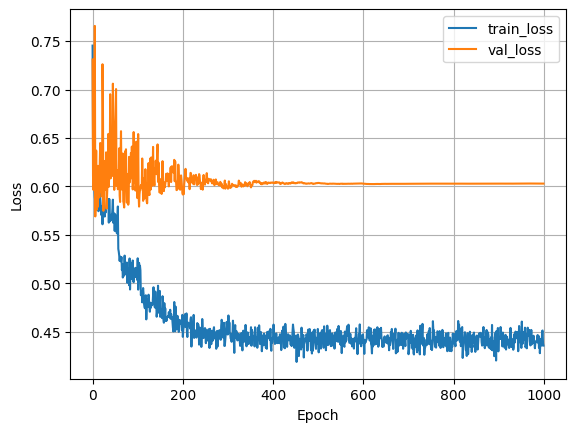

In [13]:
# Plot the loss

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
#plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

val_loss_per_epoch = history.history['val_loss']
train_loss_per_epoch = history.history['loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [14]:
def plot_PredvsTrue(y_true, y_pred):

    plt.figure(figsize=(3, 3), dpi=200)
    p1 = min(y_true)
    p2 = max(y_true)
    #p1 = 0
    #p2 = 64
    #p1 = max(max(y_pred), max(y_true))
    #p2 = min(min(y_pred), min(y_true))
    plt.plot([p1, p2], [p1, p2], 'r--', label="Exact")
    plt.scatter(y_true,y_pred,color="blue",label="Model",s=6)
    plt.xlabel('True',fontsize=15)
    plt.ylabel('Pred',fontsize=15)
    plt.legend(loc="upper left")
    plt.show()

8/8 [==============================] - 0s 900us/step
(237, 1)
(237, 1)


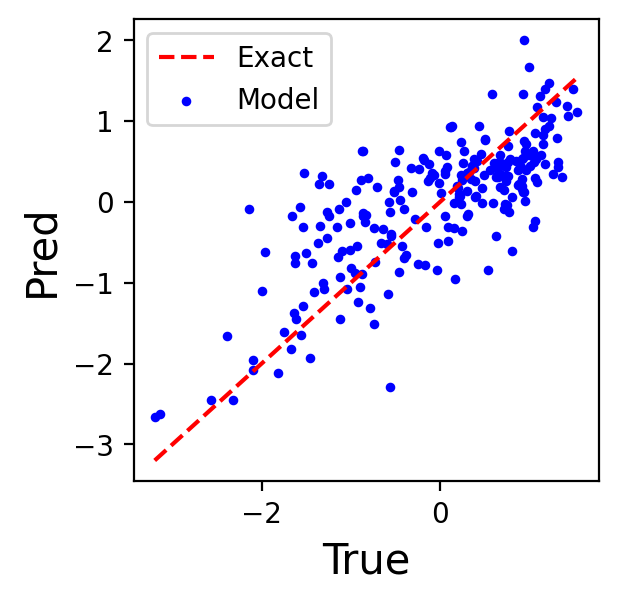

Test MAE: 0.5225943261273007
Test MSE: 0.42910582094691296


In [15]:
# Pred vs True values on test set 

y_pred = model.predict(x_test)
y_pred.shape
y_true = np.zeros((len(y_test),1))
y_true[:,0] = y_test[:]

print(y_true.shape)
print(y_pred.shape)
#print(y_true)
#print(y_pred)

plot_PredvsTrue(y_true, y_pred)

test_mae = mean_absolute_error(y_true,y_pred)
test_mse = mean_squared_error(y_true,y_pred)

print("Test MAE: "+str(test_mae))
print("Test MSE: "+str(test_mse))

In [16]:
# save model

#reloaded_model = tf.keras.models.load_model('R_model')
model.save('./Models/R_model_invariant_Nbody')

INFO:tensorflow:Assets written to: ./Models/R_model_invariant_Nbody/assets


INFO:tensorflow:Assets written to: ./Models/R_model_invariant_Nbody/assets


30/30 [==============================] - 0s 669us/step


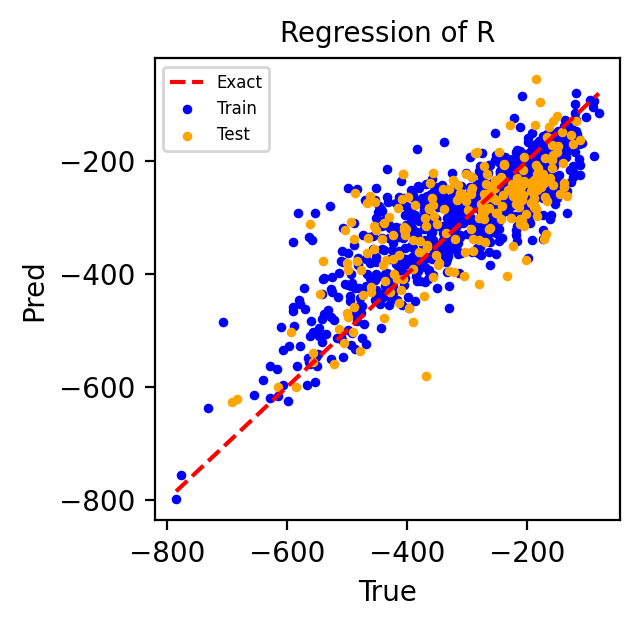

Train MAE (non-normalized): 48.1032959959647
Train RMSE (non-normalized): 65.42428888511606
Train MAPE (non-normalized): 17.65075213584452
Train R2 (non-normalized): 0.7144640177870123

Test MAE (non-normalized): 63.970818762876625
Test RMSE (non-normalized): 80.1861601072435
Test MAPE (non-normalized): 23.370048344899054
Test R2 (non-normalized): 0.5665686649183204


In [17]:
# Evaluate the model with non-normalized units on the whole dataset

y_pred_test = model.predict(x_test)
y_true_test = np.zeros((len(y_test),1))
y_true_test[:,0] = y_test[:]

y_pred_train = model.predict(x_train)
y_true_train = np.zeros((len(y_train),1))
y_true_train[:,0] = y_train[:]

y_true_test = y_true_test * R_std + R_mean
y_pred_test = y_pred_test * R_std + R_mean
y_true_test = y_true_test.ravel()
y_pred_test = y_pred_test.ravel()

y_true_train = y_true_train * R_std + R_mean
y_pred_train = y_pred_train * R_std + R_mean
y_true_train = y_true_train.ravel()
y_pred_train = y_pred_train.ravel()

#y_true_val = y_true_val * R_std + R_mean
#y_pred_val = y_pred_val * R_std + R_mean
#y_true_val = y_true_val.ravel()
#y_pred_val = y_pred_val.ravel()

plt.figure(figsize=(3, 3), dpi=200)
plt.title("Regression of R",fontsize=10)
p1 = min(y_true_train)
p2 = max(y_true_train)
plt.plot([p1, p2], [p1, p2], 'r--', label="Exact")
plt.scatter(y_true_train,y_pred_train,color="blue",label="Train",s=6)
plt.scatter(y_true_test,y_pred_test,color="orange",label="Test",s=6)
#plt.scatter(y_true_val,y_pred_val,color="green",label="Val",s=6)
plt.xlabel('True',fontsize=10)
plt.ylabel('Pred',fontsize=10)
plt.legend(loc="upper left",prop={'size': 6})
plt.show()

train_mae = mean_absolute_error(y_true_train,y_pred_train)
print("Train MAE (non-normalized): "+str(train_mae))
train_mse = mean_squared_error(y_true_train,y_pred_train,squared=False)
print("Train RMSE (non-normalized): "+str(train_mse))
train_mape = mean_absolute_percentage_error(y_true_train,y_pred_train)*100
print("Train MAPE (non-normalized): "+str(train_mape))
train_r2 = r2_score(y_true_train,y_pred_train)
print("Train R2 (non-normalized): "+str(train_r2))

print()
test_mae = mean_absolute_error(y_true_test,y_pred_test)
print("Test MAE (non-normalized): "+str(test_mae))
test_mse = mean_squared_error(y_true_test,y_pred_test,squared=False)
print("Test RMSE (non-normalized): "+str(test_mse))
test_mape = mean_absolute_percentage_error(y_true_test,y_pred_test)*100
print("Test MAPE (non-normalized): "+str(test_mape))
test_r2 = r2_score(y_true_test,y_pred_test)
print("Test R2 (non-normalized): "+str(test_r2))

#val_mae = mean_absolute_error(y_true_val,y_pred_val)
#print("val MAE (non-normalized): "+str(val_mae))

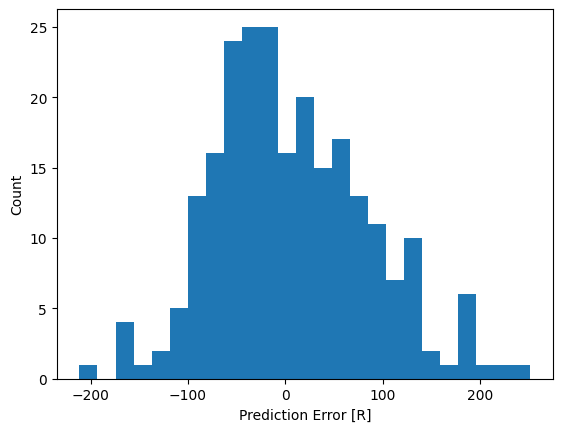

In [18]:
# Error distribution
error = y_pred_test - y_true_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [R]')
_ = plt.ylabel('Count')


In [19]:
# Which one is x_bad?
x_bad = x_test[ error>150 ]
print(x_bad)

# ohe to integer representation
x_bad_int = np.zeros(n_pos)
for i in range(n_pos):
    for j in range(n_atom_types):
        index_pos = i*n_atom_types + j
        if(x_bad[0,index_pos]>0): x_bad_int[i] = j
print(x_bad_int)

# The model seems to describe poorly data with very close substituents

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.
  0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 1. 0. 0. 0. 0.]
 [1.

[ 0.  4. 36. 37. 49. 33. 78.]
[        nan 39.98736555 66.21982941 59.90939538 65.38604591 67.27044465
 63.80425863]


/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


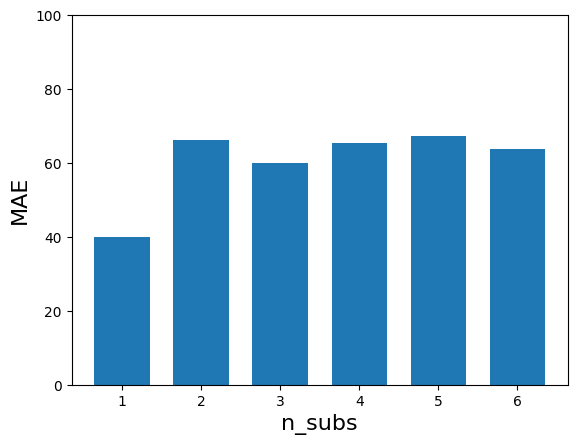

In [20]:
# Error for different nsubs on Test set

#x_test = test_features.to_numpy()

nsubs_test = np.zeros( x_test.shape[0] )
#print(x_test[0,:])

# compute number of substitutes for each data test
for i in range(len(nsubs_test)):

    # for each data, check if first input of every position is an hydrogen
    nsubs_i = 0
    for j in range(n_pos):
        if( x_test[i,j*n_atom_types]==0.0 ): # no hydrogen, hence there is a different substitute
            nsubs_i = nsubs_i+1
    nsubs_test[i] = nsubs_i
#print(nsubs_test)

error0 = []
error1 = []
error2 = []
error3 = []
error4 = []
error5 = []
error6 = []
num_subs = np.zeros(7)
for i in range(len(nsubs_test)):
    error_i = y_pred_test[i] - y_true_test[i]
    if(nsubs_test[i]==0): 
        error0.append(error_i)
        num_subs[0] +=1
    if(nsubs_test[i]==1): 
        error1.append(error_i)
        num_subs[1] +=1
    if(nsubs_test[i]==2): 
        error2.append(error_i)
        num_subs[2] +=1
    if(nsubs_test[i]==3): 
        error3.append(error_i)
        num_subs[3] +=1
    if(nsubs_test[i]==4): 
        error4.append(error_i)
        num_subs[4] +=1
    if(nsubs_test[i]==5): 
        error5.append(error_i)
        num_subs[5] +=1
    if(nsubs_test[i]==6): 
        error6.append(error_i)
        num_subs[6] +=1

error_nsubs = np.zeros(7)
error_nsubs[0] = np.mean(np.abs(error0))
error_nsubs[1] = np.mean(np.abs(error1))
error_nsubs[2] = np.mean(np.abs(error2))
error_nsubs[3] = np.mean(np.abs(error3))
error_nsubs[4] = np.mean(np.abs(error4))
error_nsubs[5] = np.mean(np.abs(error5))
error_nsubs[6] = np.mean(np.abs(error6))

print(num_subs)
print(error_nsubs)

bin_edges = np.arange(1.5,6.5+1,1)
plt.bar([0,1,2,3,4,5,6],error_nsubs[0:], width=0.7)
#bin_edges = np.arange(1.5,4.5+1,1)
#plt.bar([0,1,2,3,4],error_nsubs[0:5], width=0.7)
plt.xlabel("n_subs",fontsize=16)
plt.ylabel("MAE",fontsize=16)
plt.ylim([0,100])
plt.show()

[  1.  28. 114. 166. 160. 177. 300.]
[23.66927861 27.08919624 43.0761575  47.04613351 55.48118082 48.83646582
 48.27389246]


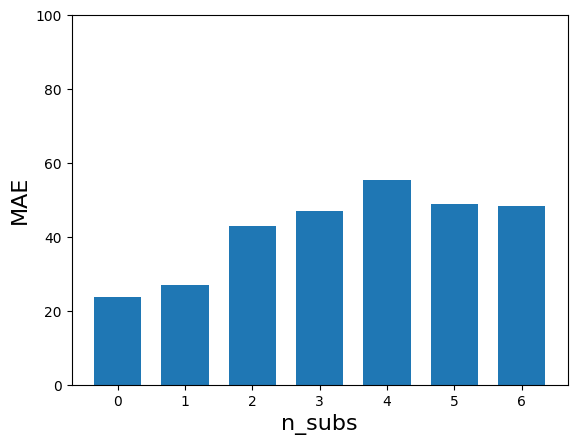

In [21]:
# Error for different nsubs on Training set

nsubs_train = np.zeros( x_train.shape[0] )
#print(x_train[0,:])

# compute number of substitutes for each data train
for i in range(len(nsubs_train)):

    # for each data, check if first input of every position is an hydrogen
    nsubs_i = 0
    for j in range(n_pos):
        if( x_train[i,j*n_atom_types]==0.0 ): # no hydrogen, hence there is a different substitute
            nsubs_i = nsubs_i+1
    nsubs_train[i] = nsubs_i
#print(nsubs_train)

error0 = []
error1 = []
error2 = []
error3 = []
error4 = []
error5 = []
error6 = []
num_subs = np.zeros(7)
for i in range(len(nsubs_train)):
    error_i = y_pred_train[i] - y_true_train[i]
    if(nsubs_train[i]==0): 
        error0.append(error_i)
        num_subs[0] +=1
    if(nsubs_train[i]==1): 
        error1.append(error_i)
        num_subs[1] +=1
    if(nsubs_train[i]==2): 
        error2.append(error_i)
        num_subs[2] +=1
    if(nsubs_train[i]==3): 
        error3.append(error_i)
        num_subs[3] +=1
    if(nsubs_train[i]==4): 
        error4.append(error_i)
        num_subs[4] +=1
    if(nsubs_train[i]==5): 
        error5.append(error_i)
        num_subs[5] +=1
    if(nsubs_train[i]==6): 
        error6.append(error_i)
        num_subs[6] +=1

error_nsubs = np.zeros(7)
error_nsubs[0] = np.mean(np.abs(error0))
error_nsubs[1] = np.mean(np.abs(error1))
error_nsubs[2] = np.mean(np.abs(error2))
error_nsubs[3] = np.mean(np.abs(error3))
error_nsubs[4] = np.mean(np.abs(error4))
error_nsubs[5] = np.mean(np.abs(error5))
error_nsubs[6] = np.mean(np.abs(error6))

print(num_subs)
print(error_nsubs)

bin_edges = np.arange(1.5,6.5+1,1)
plt.bar([0,1,2,3,4,5,6],error_nsubs[0:], width=0.7)
#bin_edges = np.arange(1.5,4.5+1,1)
#plt.bar([0,1,2,3,4],error_nsubs[0:5], width=0.7)
plt.xlabel("n_subs",fontsize=16)
plt.ylabel("MAE",fontsize=16)
plt.ylim([0,100])
plt.show()

In [22]:
# Invariance test

x1 = dataset_np[132,0:16]
x1_flip = x1.copy()
x1_flip = np.flip(x1)
#print(x1)
#print(x1_reverse)

# one-hot encode

x1_ohe = np.zeros((1,n_features))
x1_flip_ohe = np.zeros((1,n_features))
for j in range(n_pos):
    #atom_id = int(dataset_np[0,j])
    atom_id = int(x1[j])
    x1_ohe[0,j*n_atom_types+atom_id] = 1.0
    atom_id = int(x1_flip[j])
    x1_flip_ohe[0,j*n_atom_types+atom_id] = 1.0

print(x1)
y_pred1 = model.predict(x1_ohe)
print(y_pred1[0])

print()
print(x1_flip)
y_pred1_flip = model.predict(x1_flip_ohe)
print(y_pred1_flip[0])


[0. 3. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1/1 [==============================] - 0s 16ms/step
[0.13821033]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 3. 0.]
1/1 [==============================] - 0s 20ms/step
[0.13821033]
